# Heart Disease Patients Classification
###### METIS Data Science and Machine Learning Bootcamp 2022 by Krystian Krystkowiak
###### project/month(4/7) focus: CLASSIFICATION

ABSTRACT
- To predict heart disease patients, implemented and fine-tuned various classification models (KNN, Logistic Regression, Random Forest, XGBoost, Naive Bayes), utilizing techniques such as regularization, ensembling, and addressing class imbalance. Achieved Recall score of 86% with XGBoost.

### data import/cleaning/preprocessing

In [40]:
# processing imports
import pandas as pd
import numpy as np
from collections import Counter

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve

# Set style for plots
plt.style.use('fivethirtyeight')

# Show plots inline
%matplotlib inline


In [2]:
df = pd.read_csv('heart_2020_cleaned.csv')  
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [4]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [5]:
df.isnull().values.any()

False

In [6]:
df = pd.get_dummies(df, columns=['AgeCategory','Race','Diabetic', 'GenHealth'], drop_first=True)

In [7]:
df =  df[df.columns].replace({'Yes':1, 'No':0, 'Female':1,'Male':0 })

In [8]:
df.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,...,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,0.524727,0.775362,...,0.085824,0.034172,0.766779,0.021204,0.127588,0.008002,0.108435,0.291215,0.035301,0.356034
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,0.417344,...,0.280104,0.181671,0.422883,0.144065,0.333631,0.089095,0.310930,0.454323,0.184539,0.478826
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.nunique()

HeartDisease                           2
BMI                                 3604
Smoking                                2
AlcoholDrinking                        2
Stroke                                 2
PhysicalHealth                        31
MentalHealth                          31
DiffWalking                            2
Sex                                    2
PhysicalActivity                       2
SleepTime                             24
Asthma                                 2
KidneyDisease                          2
SkinCancer                             2
AgeCategory_25-29                      2
AgeCategory_30-34                      2
AgeCategory_35-39                      2
AgeCategory_40-44                      2
AgeCategory_45-49                      2
AgeCategory_50-54                      2
AgeCategory_55-59                      2
AgeCategory_60-64                      2
AgeCategory_65-69                      2
AgeCategory_70-74                      2
AgeCategory_75-7

EDA

In [10]:
#strong class imbalance - to be adressed later
df.HeartDisease.mean()

0.08559545959130067

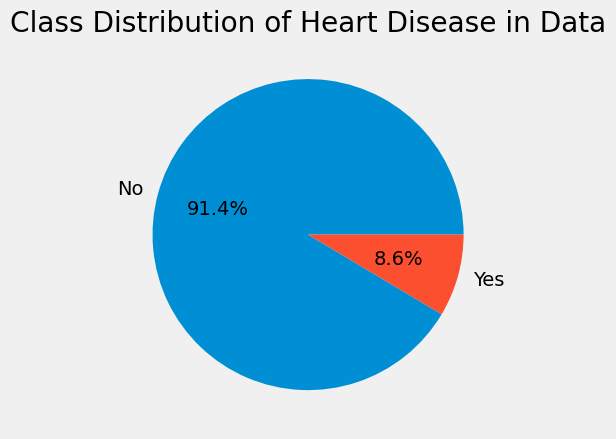

In [11]:
counts = df['HeartDisease'].value_counts()
labels = ['No', 'Yes']
plt.pie(counts, labels = labels, autopct='%1.1f%%')
plt.title("Class Distribution of Heart Disease in Data")
plt.savefig('class_distribution.png')
plt.show()


In [12]:
#considered feature engineering (combining smoking and drinking with physical activity or age did not bring visible results, proceeding to modelling

### testing diferent models

In [13]:
#Select Features
X = df.drop(columns =['HeartDisease'], axis = 1)

#Select Target 
y = df['HeartDisease']

# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, shuffle = True, test_size = .15, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, shuffle = True, test_size = .15, random_state = 42)


print(f"Shape of training feature: {X_train.shape}")
print(f"Shape of validation feature: {X_val.shape}")
print(f"Shape of testing feature: {X_test.shape}")
print(f"Shape of training label: {y_train.shape}")
print(f"Shape of validation label: {y_val.shape}")
print(f"Shape of testing label: {y_test.shape}")

Shape of training feature: (231051, 37)
Shape of validation feature: (40774, 37)
Shape of testing feature: (47970, 37)
Shape of training label: (231051,)
Shape of validation label: (40774,)
Shape of testing label: (47970,)


In [14]:
#To address class imbalance and since we have a lot of data, we will use random under-sampling to balance the classes
RUS = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_tr_us, y_tr_us = RUS.fit_resample(X_train, y_train)

In [15]:
print('Shape of training us feature:', X_tr_us.shape)
print('Shape of training us label:', y_tr_us.shape)

Shape of training us feature: (59127, 37)
Shape of training us label: (59127,)


In [16]:
#scaling
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)
X_tr_us_scaled = std_scale.fit_transform(X_tr_us) 

In [17]:
#We will be focused on recall  and our aim is to achieve 90% recall
#Our second priority is precision, as we do not want to alert patients who do not actually have heart disease

LOGISTIC REGRESSION

In [52]:
#exploring optimal parameters, i use 'balanced' parameter to additionally address class imbalance, runned couple times

parameters = {'penalty':['l2'],
'C':[1, 10, 20, 30, 40, 50, 100, 1000],
'class_weight':[{0:1, 1:3},{0:1, 1:20},{0:1, 1:5}, 'balanced']
}

logreg = LogisticRegression()

grid_search = RandomizedSearchCV(estimator = logreg,  
                           param_distributions = parameters,
                           n_iter = 10, #number of parrameter settings = 10
                           scoring = 'recall',
                           n_jobs = -1, #all procesors
                           cv = 5 #cross validation folds
                                )

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Optimal Parameters for Logistic Regression: ", best_params)

logreg = LogisticRegression(**best_params)
validation(logreg)

Optimal Parameters for Logistic Regression:  {'penalty': 'l2', 'class_weight': {0: 1, 1: 20}, 'C': 20}
__________________________________________________ 

model: LogisticRegression(C=20, class_weight={0: 1, 1: 20})
 accuracy on training set: 0.4854804065824412
 accuracy on validation set: 0.24728993966743512
 accuracy on test set: 0.2486345632687096
 precission: 0.10034906573582471
 precission on test set: 0.10402926756427167
 recall: 0.9938988959907031
 recall on test set: 0.9900521080056846
 F1: 0.1822929155676338
 F1 on test set: 0.188275566966196
__________________________________________________ 



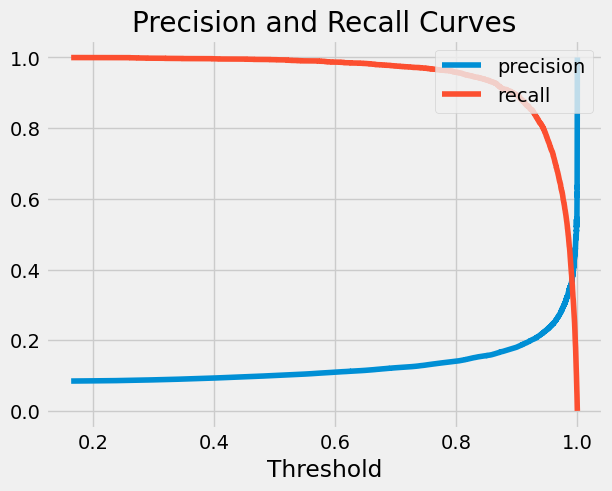

In [54]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 
    
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, logreg.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves')
plt.savefig('precision_recall_curve.png');

In [23]:
#Predict class 1 if probability of being in class 1 is greater than threshold
#(model.predict(X_test) does this automatically with a threshold of 0.5)    
def make_confusion_matrix(m, threshold=0.5):
    m.fit(X_tr_us_scaled, y_tr_us)
    y_predict = (m.predict_proba(X_val_scaled)[:, 1] >= threshold)
    heart_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(heart_confusion, cmap='Blues', annot=True, square=True, fmt='d',
                xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')


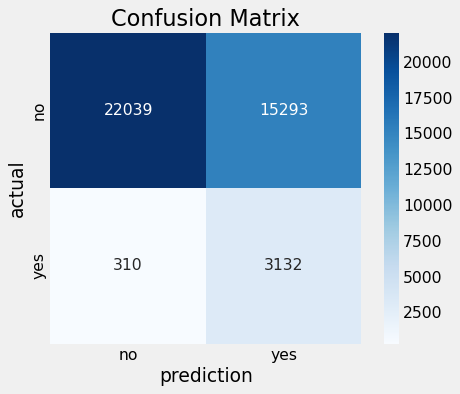

In [61]:
make_confusion_matrix(logreg, 0.88)

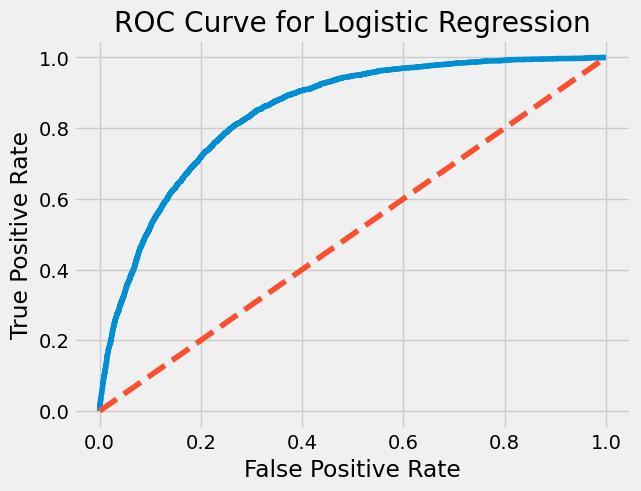

In [57]:
#lm = LogisticRegression(C=30, class_weight='{0: 1, 1: 20}').fit(X_tr_us_scaled, y_tr_us)

fpr, tpr, _ = roc_curve(y_val, logreg.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve.png');

In [58]:
#validation function
def validation(m, threshold=0.5):
    m.fit(X_tr_us_scaled, y_tr_us)
    y_pred = (m.predict_proba(X_val_scaled)[:, 1] >= threshold)
    y_t_pred = (m.predict_proba(X_test_scaled)[:, 1] >= threshold)
    
    print('_'*50, '\n')
    print(f'model: {str(m)}')
    print(f' accuracy on training set: {m.score(X_tr_us_scaled, y_tr_us)}')
    print(f' accuracy on validation set: {m.score(X_val_scaled, y_val)}')
    print(f' accuracy on test set: {m.score(X_test_scaled, y_test)}')
    print(f' precission: {precision_score(y_val,y_pred)}')
    print(f' precission on test set: {precision_score(y_test,y_t_pred)}')
    print(f' recall: {recall_score(y_val,y_pred)}')
    print(f' recall on test set: {recall_score(y_test,y_t_pred)}')
    print(f' F1: {f1_score(y_val,y_pred)}')
    print(f' F1 on test set: {f1_score(y_test,y_t_pred)}')
    print('_'*50, '\n')

In [60]:
#class_weight is adressing class imbalance and improving score
#interesting that in that case accuracy is higher on validation set
validation(logreg, threshold=0.88)

__________________________________________________ 

model: LogisticRegression(C=20, class_weight={0: 1, 1: 20})
 accuracy on training set: 0.4854804065824412
 accuracy on validation set: 0.24728993966743512
 accuracy on test set: 0.2486345632687096
 precission: 0.1699864314789688
 precission on test set: 0.17553387334315168
 recall: 0.9099360836722835
 recall on test set: 0.9033633349123638
 F1: 0.2864590478803677
 F1 on test set: 0.2939499036608863
__________________________________________________ 



KNN

In [67]:
#exploring optimal parameters for KNN

parameters = {'n_neighbors':[3,5,7,9,11,13],
'weights':['uniform', 'distance']}

knn = KNeighborsClassifier()

grid_search = RandomizedSearchCV(estimator = knn,  
                           param_distributions = parameters,
                           scoring = 'recall',
                           cv = 5)


grid_search.fit(X_tr_us_scaled, y_tr_us)

best_params = grid_search.best_params_
print("Optimal Parameters for KNN: ", best_params)

knn = KNeighborsClassifier(**best_params)
validation(knn)

Optimal Parameters for KNN:  {'weights': 'distance', 'n_neighbors': 13}
__________________________________________________ 

model: KNeighborsClassifier(n_neighbors=13, weights='distance')
 accuracy on training set: 0.9979873830906354
 accuracy on validation set: 0.8209398145877275
 accuracy on test set: 0.8131749009797791
 precission: 0.26472381416900376
 precission on test set: 0.2597810662882627
 recall: 0.6307379430563625
 recall on test set: 0.6070582662245382
 F1: 0.3729279395344843
 F1 on test set: 0.3638557637705849
__________________________________________________ 



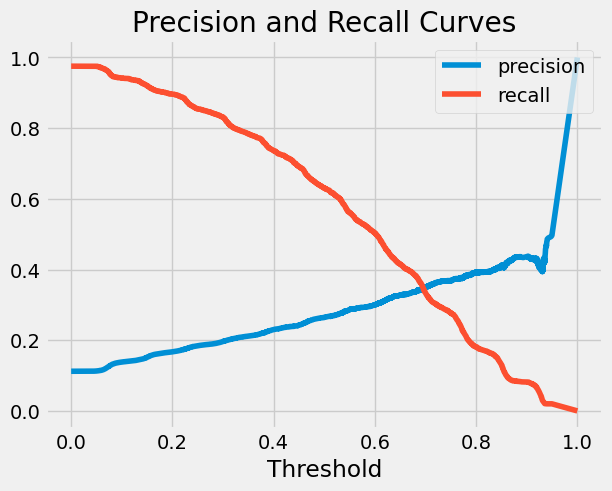

In [68]:
#knn = knn(n_neighbors=13, weights='distance').fit(X_tr_us_scaled, y_tr_us)
    
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves')
plt.savefig('precision_recall_curve - KNN.png');

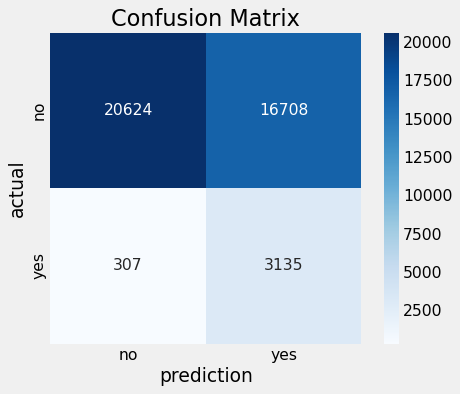

In [69]:
make_confusion_matrix(knn, 0.16)

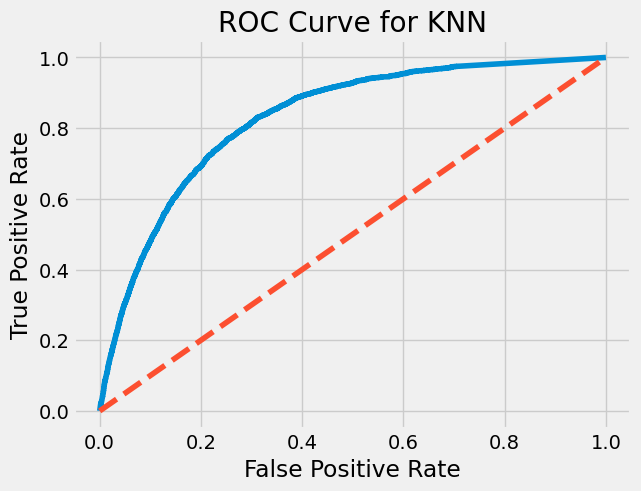

In [70]:
#knn = knn(n_neighbors=13, weights='distance').fit(X_tr_us_scaled, y_tr_us)

fpr, tpr, _ = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve for KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve.png');

In [71]:
validation(knn, threshold=0.16)

__________________________________________________ 

model: KNeighborsClassifier(n_neighbors=13, weights='distance')
 accuracy on training set: 0.9979873830906354
 accuracy on validation set: 0.8209398145877275
 accuracy on test set: 0.8131749009797791
 precission: 0.15799022325253237
 precission on test set: 0.1610969387755102
 recall: 0.9108076699593259
 recall on test set: 0.8974419706300332
 F1: 0.2692720635602319
 F1 on test set: 0.27315982986086085
__________________________________________________ 



RANDOM FOREST

In [72]:
#exploring optimal parameters for RANDOM FOREST

parameters = {'class_weight':['balanced'],
              'bootstrap': [False],
              'max_depth': [70, 80],
              'max_features': [3, 4],
              'min_samples_leaf': [6, 7],
              'min_samples_split': [3, 4],
              'n_estimators': [900, 1000, 1100]}

randomforest = RandomForestClassifier()

grid_search = RandomizedSearchCV(estimator = randomforest,  
                           param_distributions = parameters,
                           n_iter = 10, #number of parrameter settings = 10
                           scoring = 'recall',
                           n_jobs = -1, #all procesors
                           cv = 5 #cross validation folds
                                )


grid_search.fit(X_tr_us_scaled, y_tr_us)

best_params = grid_search.best_params_
print("Optimal Parameters for Random Forest: ", best_params)

randomforest = RandomForestClassifier(**best_params)
validation(randomforest)

Optimal Parameters for Random Forest:  {'n_estimators': 900, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 4, 'max_depth': 70, 'class_weight': 'balanced', 'bootstrap': False}
__________________________________________________ 

model: RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=70,
                       max_features=4, min_samples_leaf=7, min_samples_split=3,
                       n_estimators=900)
 accuracy on training set: 0.7869670370558289
 accuracy on validation set: 0.7328199342718399
 accuracy on test set: 0.7264748801334168
 precission: 0.21609265467845168
 precission on test set: 0.2168628698695514
 recall: 0.8239395700174317
 recall on test set: 0.8072003789673141
 F1: 0.3423880236629241
 F1 on test set: 0.34187691227366207
__________________________________________________ 



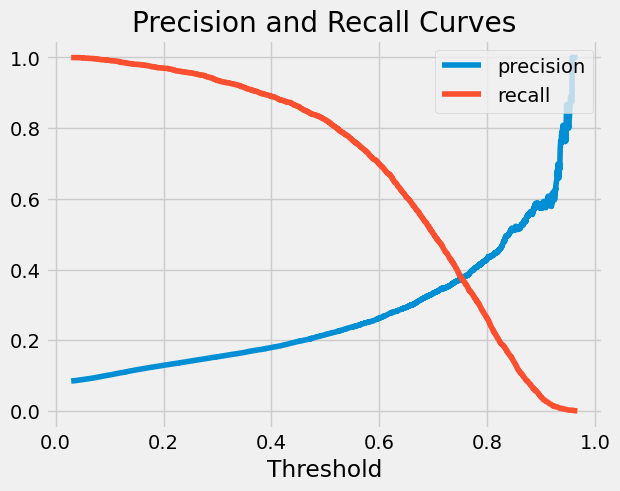

In [73]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, randomforest.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves')
plt.savefig('precision_recall_curve - Random Forest.png');

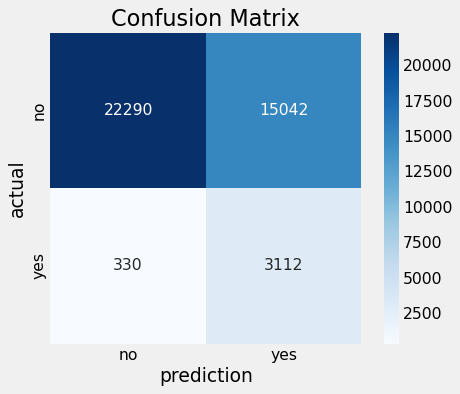

In [80]:
make_confusion_matrix(randomforest, 0.37)

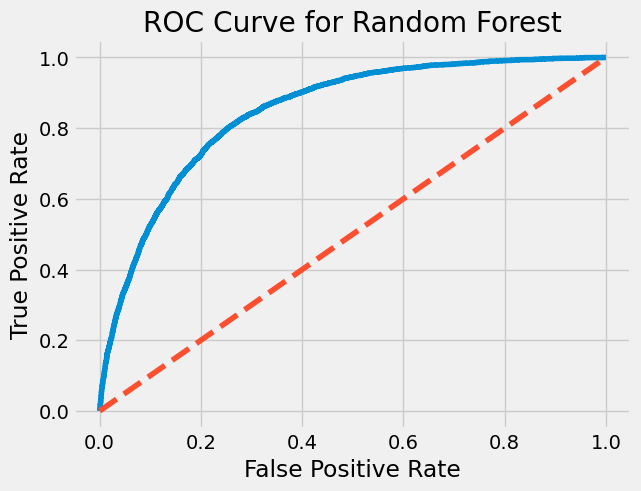

In [75]:
fpr, tpr, _ = roc_curve(y_val, randomforest.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve for Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve - Random Forest.png');

In [79]:
validation(randomforest, threshold=0.37)

__________________________________________________ 

model: RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=70,
                       max_features=4, min_samples_leaf=7, min_samples_split=3,
                       n_estimators=900)
 accuracy on training set: 0.787000862550104
 accuracy on validation set: 0.733016137734831
 accuracy on test set: 0.726912653741922
 precission: 0.17128075293081624
 precission on test set: 0.17600521221146687
 recall: 0.9041255084253341
 recall on test set: 0.8957839886309806
 F1: 0.28800148072740733
 F1 on test set: 0.2942045896538312
__________________________________________________ 



XGBoost

In [81]:
#exploring optimal parameters for XGBOOST

parameters = {'eval_metric':['rmse'],
              'use_label_encoder':['False'],
              'n_estimators':[int(x) for x in np.linspace(start = 700, stop = 1000, num = 5)],
              'learning_rate':[round(x,2) for x in np.linspace(start = .0, stop = .2, num = 20)],
              'min_child_weight': [1,2,3],
              'gamma': [1.1,1.3,1.5],
              'subsample': [.5,.6,.7],
              'scale_pos_weight':[6,8,10],
              'max_depth': range(6,8,1)
              }

xgb = XGBClassifier(use_label_encoder=False)

grid_search = RandomizedSearchCV(estimator = xgb,  
                           param_distributions = parameters,
                           n_iter = 10, #number of parrameter settings = 10
                           scoring = 'recall',
                           n_jobs = -1, #all procesors
                           cv = 5 #cross validation folds
                                )


grid_search.fit(X_tr_us_scaled, y_tr_us)

best_params = grid_search.best_params_
print("Optimal Parameters for XGBoost: ", best_params)

xgb = XGBClassifier(**best_params)
validation(xgb)

/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/krystiankrystkowiak/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecate

Optimal Parameters for XGBoost:  {'use_label_encoder': 'False', 'subsample': 0.7, 'scale_pos_weight': 10, 'n_estimators': 925, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.03, 'gamma': 1.3, 'eval_metric': 'rmse'}
__________________________________________________ 

model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='rmse', gamma=1.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=925, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.7,
              tree_method='exact', use_label_encoder='False',
              validate_parameters=1, verbosity=None)
 accuracy on trai

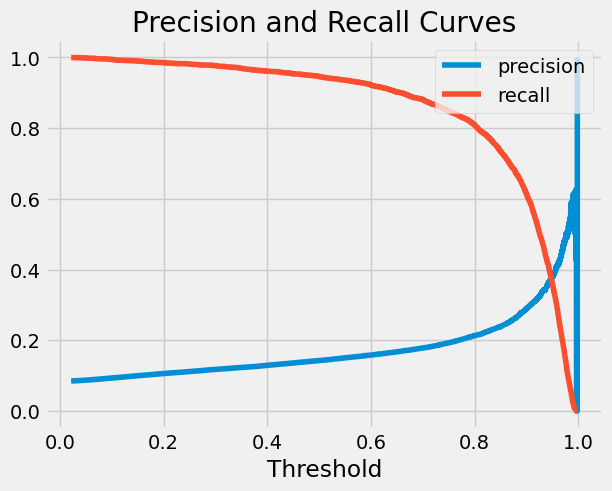

In [82]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, xgb.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves')
plt.savefig('precision_recall_curve -  XGBoost.png');

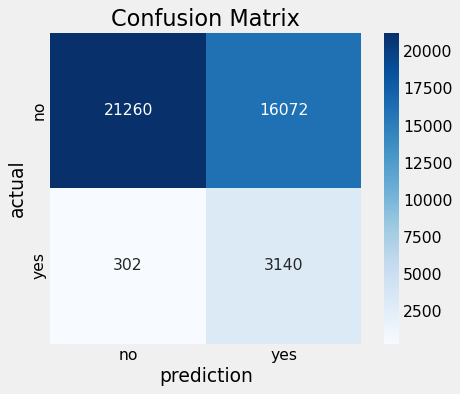

In [90]:
make_confusion_matrix(xgb, 0.63)

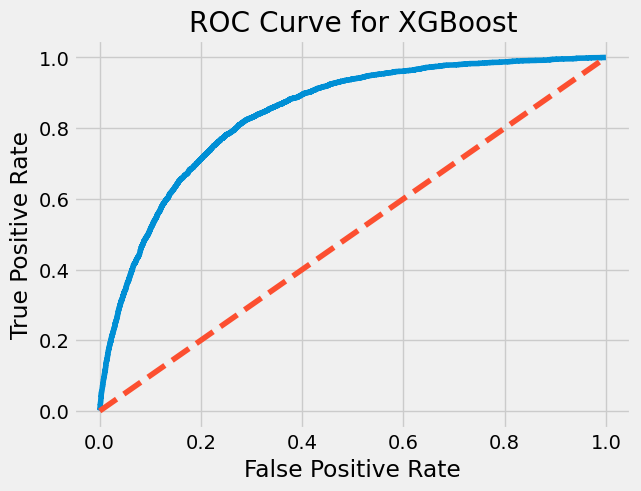

In [91]:
fpr, tpr, _ = roc_curve(y_val, xgb.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve for XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve - XGBoost.png');

In [89]:
validation(xgb, threshold=0.63)

__________________________________________________ 

model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='rmse', gamma=1.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=925, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.7,
              tree_method='exact', use_label_encoder='False',
              validate_parameters=1, verbosity=None)
 accuracy on training set: 0.6725861281647978
 accuracy on validation set: 0.5145681071270908
 accuracy on test set: 0.5149676881384199
 precission: 0.16343951696856132
 precission on test set: 0.16789895255699322
 recall: 0.9122603137710633
 

Naive Bayes

In [100]:
nb = BernoulliNB() 
nb.fit(X_tr_us_scaled, y_tr_us)

BernoulliNB()

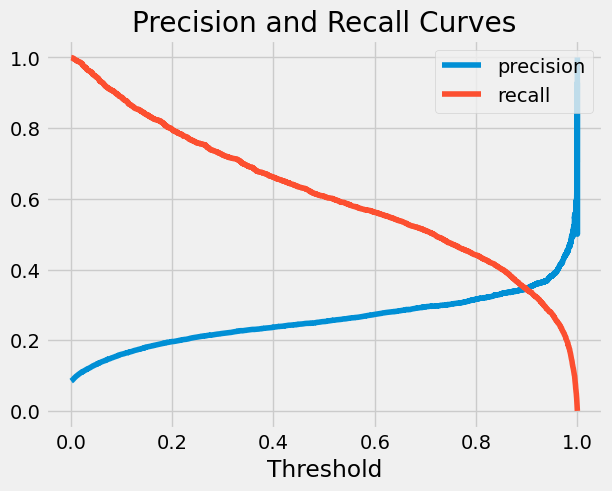

In [101]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, nb.predict_proba(X_val_scaled)[:,1])

plt.figure(dpi=100)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper right')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves')
plt.savefig('precision_recall_curve - Naive Bayes.png');

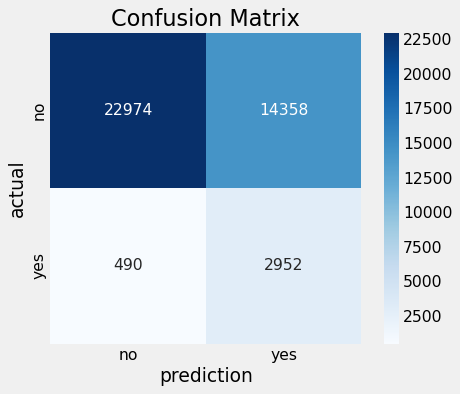

In [155]:
make_confusion_matrix(nb, 0.125)

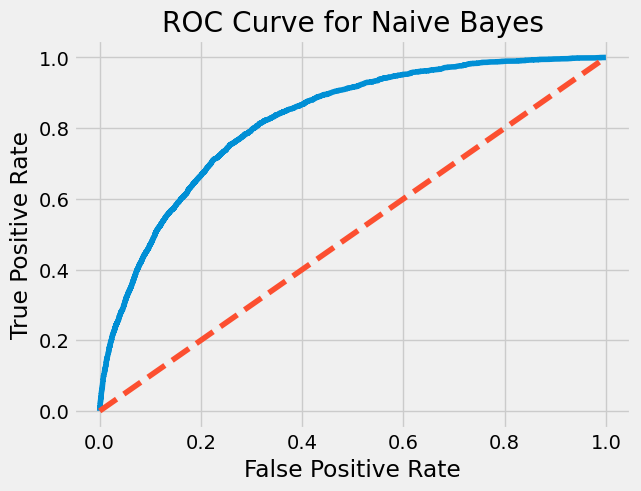

In [102]:
fpr, tpr, _ = roc_curve(y_val, nb.predict_proba(X_val_scaled)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve for Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve - Naive Bayes.png');

In [105]:
validation(nb, threshold=0.08)

__________________________________________________ 

model: BernoulliNB()
 accuracy on training set: 0.7591624807617501
 accuracy on validation set: 0.8153725413253544
 accuracy on test set: 0.8124244319366271
 precission: 0.14982728842832468
 precission on test set: 0.1541796669232951
 recall: 0.9073213248111563
 recall on test set: 0.9012316437707247
 F1: 0.25718520958576957
 F1 on test set: 0.2633126881422788
__________________________________________________ 

